# GRACE satellite data

Using the GSFC solution

Data from here (using the hdf5 file, but note that there is a PDF with instructions included in the ascii .zip file): https://neptune.gsfc.nasa.gov/gngphys/index.php?section=413 

Visualization tool here : http://ccar.colorado.edu/grace/gsfc.html

In [74]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from scipy import ndimage
from scipy.interpolate import Rbf, griddata
from scipy.optimize import leastsq, curve_fit
from scipy.stats import chi2
from scipy.ndimage.filters import gaussian_filter

import cartopy.crs as ccrs
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

#%matplotlib notebook
%matplotlib inline

In [75]:
mascons = dict()
with h5py.File('GSFC.glb.200301_201607_v02.4.h5','r') as data:
    mascons['location'] = data.get('/mascon/location').value.squeeze()
    mascons['basin'] = data.get('/mascon/basin').value.squeeze()
    mascons['lon_center'] = data.get('/mascon/lon_center').value.squeeze()
    mascons['lat_center'] = data.get('/mascon/lat_center').value.squeeze()
    mascons['lon_span'] = data.get('/mascon/lon_span').value.squeeze()
    mascons['lat_span'] = data.get('/mascon/lat_span').value.squeeze()
    mascons['yr'] = data.get('/time/yyyy_doy_yrplot_middle').value.squeeze()
    mascons['cmwe'] = data.get('/solution/cmwe').value.squeeze()
    mascons['area_km2'] = data.get('/mascon/area_km2').value.squeeze()
    mascons['leakage_trend'] = data.get('/uncertainty/leakage_trend').value.squeeze()
    mascons['leakage_2sigma'] = data.get('/uncertainty/leakage_2sigma').value.squeeze() 
    mascons['noise_2sigma'] = data.get('/uncertainty/noise_2sigma').value.squeeze()    
    


## Check if I can reproduce the Greenland figure in GSFC_mascons_HDF5_format_v02.4.pdf

(199, 148) (148,) (199,)
0.04057926264387635


Text(0.5,1,'NASA GSFC v02.3c: Greenland Ice Sheet')

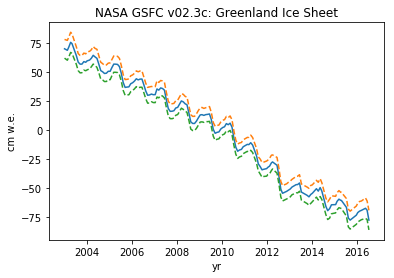

In [76]:
Gndl = np.where(mascons['location'] == 1)[0]
N = float(len(Gndl))
Z = 22 #where does this come from??
t = mascons['yr'][2]
print(mascons['cmwe'][Gndl,:].shape, t.shape, Gndl.shape)
cG = np.array([])
cGe = np.array([])
cmwe2GT = mascons['area_km2'][Gndl]*1e-5
for i in range(len(t)):
    cG = np.append(cG, np.sum(mascons['cmwe'][Gndl,i] * mascons['area_km2'][Gndl]*1e-5))
    leakage_trend = np.abs(np.sum( mascons['leakage_trend'][Gndl,i]*cmwe2GT))
    leakage_2sigma = np.sum(mascons['leakage_2sigma'][Gndl,i]*cmwe2GT)
    noise_2sigma = np.sum(mascons['noise_2sigma'][Gndl,i]*cmwe2GT)
    cGe = np.append(cGe, leakage_trend + (leakage_2sigma + noise_2sigma)/(N/Z)**0.5)
    
GT2cmwe = 1./(np.sum(mascons['area_km2'][Gndl])*1e-5)
print(GT2cmwe)
f,ax = plt.subplots(1,1)
ax.plot(t, cG * GT2cmwe)
ax.plot(t, (cG + cGe) * GT2cmwe, "--")
ax.plot(t, (cG - cGe) * GT2cmwe, "--")
ax.set_xlabel('yr')
ax.set_ylabel('cm w.e.')
ax.set_title('NASA GSFC v02.3c: Greenland Ice Sheet')

## And the Amazon Basin

In [77]:
def makeCmweGrid(ti, Ngridx, Ngridy, c = np.array([]), extent = [0, 360, -90, 90], reg = range(len(mascons['lon_center'])), \
                sigma = None, size = None, alpha = None, sigmam = None, order = None, pct = 70, zm = None):
    x =  mascons['lon_center'][reg]
    xl = mascons['lon_center'][reg] - 0.5 * mascons['lon_span'][reg]
    xh = mascons['lon_center'][reg] + 0.5 * mascons['lon_span'][reg]
    y =  mascons['lat_center'][reg]
    yl = mascons['lat_center'][reg] - 0.5 * mascons['lat_span'][reg]
    yh = mascons['lat_center'][reg] + 0.5 * mascons['lat_span'][reg]

    if (c.size == 0):
        z = mascons['cmwe'][reg,ti] * mascons['area_km2'][reg]*1e-5
    else:
        z = c[reg]

    xgrid = np.linspace(extent[0], extent[1], Ngridx)
    ygrid = np.linspace(extent[2], extent[3], Ngridy)

    xv, yv = np.meshgrid(xgrid, ygrid)
    xvf = xv.flatten()
    yvf = yv.flatten()

    #fast, but looks too "jagged" and doesn't reproduce the mascons
    #zgrid = griddata((x,y), z, (xv, yv), method=method, fill_value = 0.)

    #zSmooth = SmoothBivariateSpline(x,y,z)
    #zgrid = zSmooth(xgrid,ygrid)
    
    #slow, but produces images as expected from the data
    #not sure why this needs to be flipped?
    #zgrid = np.zeros((len(xgrid), len(ygrid)))
    if (zm == None):
        zm = np.mean(z)
    zgrid = np.full((len(ygrid), len(xgrid)), zm)
    for i,xx in enumerate(xgrid):
        for j,yy in enumerate(ygrid):
            box = np.where(np.logical_and(np.logical_and(yl <= yy, yh >= yy),  np.logical_and(xl <= xx, xh >= xx) ))[0]
            if (len(box) > 0):
                zgrid[j,i] = np.mean(z[box])
                #print(np.mean(z[box]))
            #else:
                #print("BAD BOX", xx, yy, box)
                
#any smoothing or filtering?
#http://www.scipy-lectures.org/advanced/image_processing/#image-filtering
    if (sigmam != None):
        zgrid = ndimage.percentile_filter(zgrid, pct, sigmam)
    if (sigma != None and alpha == None):
        zgrid = ndimage.gaussian_filter(zgrid, sigma)
    if (size != None):
        zgrid = ndimage.uniform_filter(zgrid, size = size)
    if (alpha != None):
        zgridf= ndimage.gaussian_filter(zgrid, sigma)
        zgrid += alpha * (zgrid - zgridf)
    if (order != None):
        zgrid = ndimage.spline_filter(zgrid, order)

        
    print(z.shape, zgrid.shape)
    
    return zgrid

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


(484,) (100, 100)


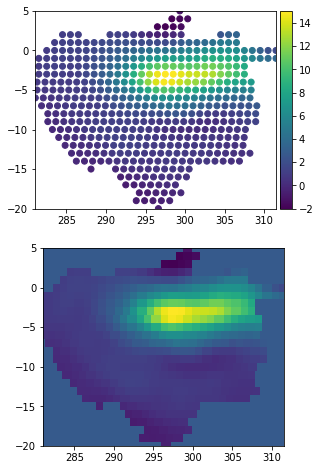

In [78]:
Amz = np.where(np.logical_and(mascons['location'] == 80, mascons['basin'] == 3005))[0]
t = 76
x = np.array([])
y = np.array([])
z = np.array([])
for i in Amz:
    #x = np.append(x, np.array([-1., 1., 1., -1.]) * mascons['lon_span'][i]/2. + mascons['lon_center'][i])
    #y = np.append(y, np.array([-1., -1., 1., 1.]) * mascons['lat_span'][i]/2. + mascons['lat_center'][i])
    x = np.append(x, mascons['lon_center'][i])
    y = np.append(y, mascons['lat_center'][i])
    z = np.append(z, mascons['cmwe'][i,t] * mascons['area_km2'][i]*1e-5)


f,ax = plt.subplots(2,1, figsize=(5, 8))

vmin = min(z)
vmax = max(z)
p0 = ax[0].scatter(x,y, c=z, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p0, cax = cax)
#f.colorbar(p0, ax = ax[0])

N = 100.
extent = [min(x), max(x), min(y), max(y)]
zgrid = makeCmweGrid(t, N, N, extent = extent, reg = Amz)#, sigma = 2)
ax[1].imshow(zgrid, extent = extent, origin="lower", vmin=vmin, vmax=vmax)
ax[0].set_xlim(extent[0], extent[1])
ax[0].set_ylim(extent[2], extent[3])

for a in ax:
    a.set_aspect('equal')

## Try to estimate the densest region of points so I know how to construct my image

720
360
1.0


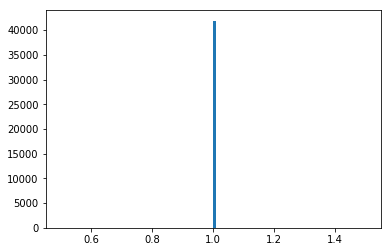

In [79]:
x =  mascons['lon_center']
xl = mascons['lon_center'] - 0.5 * mascons['lon_span']
xh = mascons['lon_center'] + 0.5 * mascons['lon_span']
y =  mascons['lat_center']
yl = mascons['lat_center'] - 0.5 * mascons['lat_span']
yh = mascons['lat_center'] + 0.5 * mascons['lat_span']

size = 0.5
xgrid = np.arange(0,360, size)
ygrid = np.arange(-90,90, size)
print(len(xgrid))
print(len(ygrid))
#print(min(x), max(x), min(y), max(y))
dens = np.array([])
for i,xx in enumerate(xgrid):
    for j,yy in enumerate(ygrid):
        reg = np.where(np.logical_and(np.logical_and(y <= yy + size/2., y >= yy - size/2.),  \
                                      np.logical_and(x <= xx + size/2., x >= xx - size/2.) ))[0]
        if (len(reg) > 0):
            dens = np.append(dens, len(reg))
f = plt.figure()
foo = plt.hist(dens,bins=100)
print(max(dens))

## Make an image with all the data at a given time

A full map in Cylindrical Equidistant projection (aka Equirectangular projection or Plate Carrée).  

I will use cartopy http://geologyandpython.com/maps.html for the projection (when necessary)


In [80]:
import cartopy.crs as ccrs

#these are defaults that I want to keep for both this t=0 texture and the fit textures
#Ngrid = int(2.**9.)
Ngrid = int(360)
print(Ngrid)
method = "nearest"
sigma = None
proj = ccrs.PlateCarree(180)

360


### Scatter plot of the data at t=0

41168 41168 41168 -11.13989100393677 28.676903189001468 -455.4471740722656 279.88421630859375


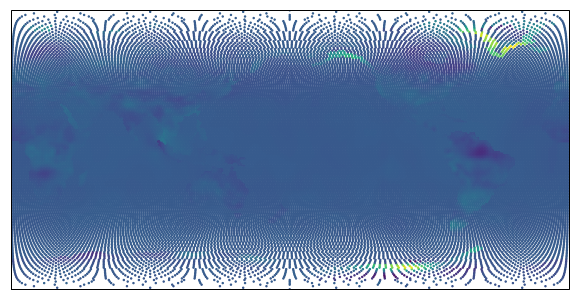

In [81]:
ti = 0 #take the initial time
x =  mascons['lon_center']
y =  mascons['lat_center']
z = mascons['cmwe'][:,ti] * mascons['area_km2']*1e-5
print(x.size, y.size, z.size, min(z), max(z), min(mascons['cmwe'].flatten()), max(mascons['cmwe'].flatten()))

#the degrees in the arg control the central longitude in the scatter plot.  
#I can't do that for the image for some reason.  (can't include ccrs.Geodetic). So this is off by 180 degrees
f,ax = plt.subplots(1,1, figsize=(10, 10), subplot_kw={'projection': proj})

vminc = min(z)
vmaxc = max(z)

ax.projection = proj # Here we change projection for each subplot.
ax.set_global() # Set global extention
p0 = ax.scatter(x,y, c=z, vmin=vminc, vmax=vmaxc, transform=ccrs.Geodetic(), s = 2)
ax.set_aspect('equal')


## Now using my function

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(41168,) (360, 720)


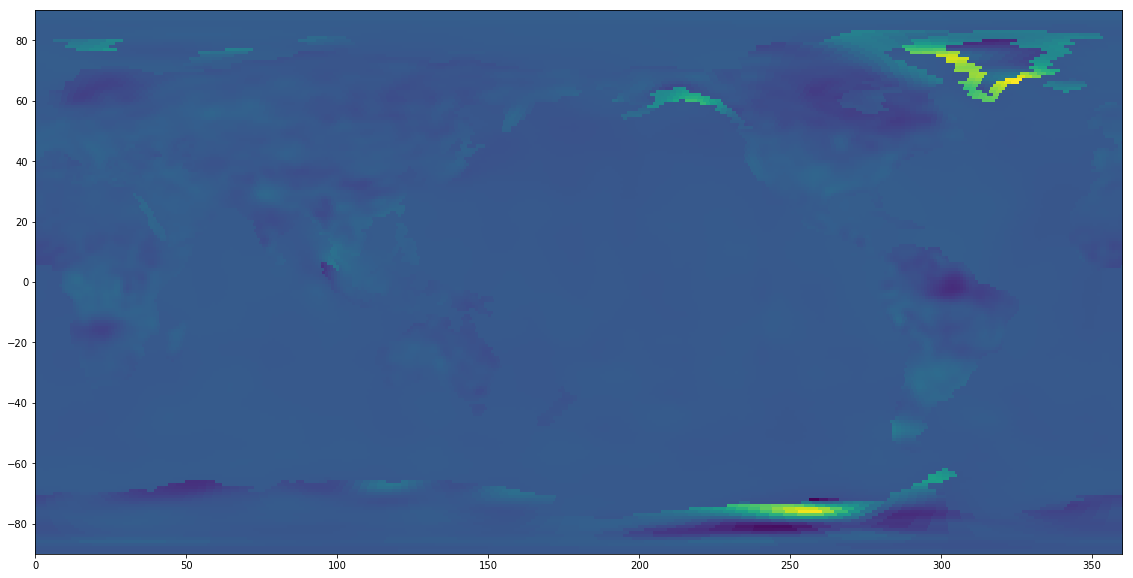

In [82]:
extent = [0, 360, -90, 90]
#land = np.where(mascons['location'] <= 80)[0] #This does not include the region around greenland?

zgrid = makeCmweGrid(ti, Ngrid*2., Ngrid, extent = extent, sigma = sigma)#, zm = vminc)#, reg = land)
f,ax = plt.subplots(1,1, figsize=(20, 10))
ax.imshow(zgrid, extent = extent, origin="lower", vmin=vminc, vmax=vmaxc)


### min and max of the data over all t

In [83]:
times = mascons['yr'][2]
cmin = 0.
cmax = 0.
for i,t in enumerate(times):
    z = mascons['cmwe'][:,i] * mascons['area_km2']*1e-5
    cmin = np.min([cmin, np.min(z)])
    cmax = np.max([cmax, np.max(z)])
    
print(cmin, cmax)
print(len(times)/3)

-56.14183452995301 34.58935093038941
49.333333333333336


### Try to fit a polynomial and sin curve to each pixel in the image as a function of time

In [114]:
def calcChi2(y, ye, m):
    return np.sum((y - m)**2. / ye**2.)

# cmap = plt.get_cmap('viridis') 
# f,ax = plt.subplots(3,1, figsize=(10,5))
# ax[0].set_ylim(-10,10)
# ax[1].set_ylim(-3,3)
# ax[2].set_ylim(-3,3)

t = mascons['yr'][2]
t0 = min(t)
t = t - t0

#for second-order effects, fit sin curve
def cfitFunc(t, fA, fp):
    #require that c is zero and the period is one year
    p = [fA, fp]
    return p[0] * np.sin(2.*np.pi *(t + p[1]))

r1 = np.array([])
g1 = np.array([])
b1 = np.array([])
a1 = np.array([])
r2 = np.array([])
g2 = np.array([])
b2 = np.array([])
a2 = np.array([])
chi2r = np.array([])

#to find how many fits are rejected at 3sigma confidence
bad = 0
dof = len(t) - 6
xx = np.linspace(0,500,1000)
cc = chi2.cdf(xx, dof)
clim = np.interp(0.997,cc,xx)
print("dof : ", dof)
print("chi2_lim : ", clim)
#plt.semilogy(xx,1. - cc)
#plt.plot([clim,clim],[0,1])


for i, m in enumerate(mascons['location']):
    cmwe2GT = mascons['area_km2'][i]*1e-5
    c = mascons['cmwe'][i,:] * cmwe2GT
    leakage_trend = np.abs(mascons['leakage_trend'][i,:]*cmwe2GT)
    leakage_2sigma = mascons['leakage_2sigma'][i,:]*cmwe2GT
    noise_2sigma = mascons['noise_2sigma'][i,:]*cmwe2GT
    cGe = leakage_trend + (leakage_2sigma + noise_2sigma)/(N/Z)**0.5
    
    #normalize by the value at t=0
    #c0 = c[0]
    #cGe0 = cGe[0]
    #cGe = ( (1./c0)**2.*cGe**2. +  (c/c0**2.)**2.*cGe0**2.)**0.5 #propagation of errors 
    #c = c/c0
    
    #first-order is polynomial
    p = np.polyfit(t, c,  3, w = 1./cGe)

    r1 = np.append(r1,p[0])
    g1 = np.append(g1,p[1])
    b1 = np.append(b1,p[2])
    a1 = np.append(a1,p[3])
    #b2 = np.append(b2, p[4])
    #a2 = np.append(a2, p[5])

    #b2 = np.append(b2, c0)
    #b2 = np.append(b2, p[3])
    
    cf = np.poly1d(p) 

    #2nd order is sin curve
    c2nd = c - cf(t)

    #one sin curve limited such that p = 1 yr and c = 0
    popt, pcov = curve_fit(cfitFunc, t, c2nd, p0 = [np.std(c2nd), 0.], sigma=cGe)#, bounds=[[0, 0], [np.inf, 1.]])#,sigma=cGe)
    fA, fp = popt.ravel()
    fit = cf(t) + fA * np.sin(2.*np.pi*(t + fp))
    r2 = np.append(r2, fA)
    g2 = np.append(g2, fp)
    #print(fA, fp)
    
    #fit = cf(t) + (fA * np.sin(2.*np.pi*t + fp)) * (np.sin(2.*np.pi/fw2*t + fp2))
    c2 = calcChi2(c,cGe, fit)
    chi2r = np.append(chi2r, c2/dof)
    #print(c2/len(t), chi2.cdf(c2, dof))
    if (c2 > clim):
        bad += 1
#     #ax[0].errorbar(t,c ,cGe, color=cmap(bad), alpha = 0.1)
#     ax[0].plot(t,c , color=cmap(bad), alpha = 0.1)
#     ax[0].plot(t,fit, color='k', alpha = 0.1)
#     ax[1].plot(t,c - cf(t), color=cmap(bad), alpha = 0.1)
#     ax[2].plot(t,c - fit, color=cmap(bad), alpha = 0.1)
    
    #plt.subplots_adjust(hspace = 0)
    
    if (i == 0):
        print(p)
        print(np.poly1d(p))
        
#     if (i > 100):
#         break
        
print("N tot = ", len(mascons['location']))
print("N bad = ", bad)
print("frac bad = ",bad / len(mascons['location']) )

dof :  142
chi2_lim :  192.67702200308736
[ 0.01797655 -0.38508793 -0.14502796 12.75461226]
         3          2
0.01798 x - 0.3851 x - 0.145 x + 12.75
N tot =  41168
N bad =  1741
frac bad =  0.0422901282549553


## Check the range of the parameters

-0.0222 0.0461 -1.1247 0.5629 -5.051 3.0189 -15.8233 32.3872
-3.9773 8.284 -0.3349 0.3329


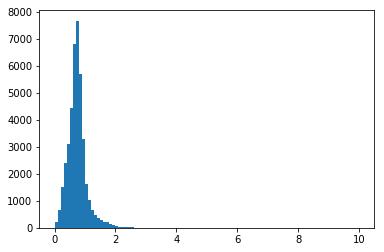

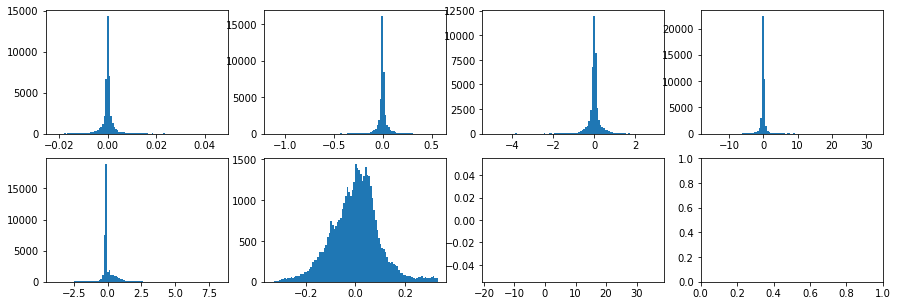

In [115]:
f, ax = plt.subplots(1)
ax.hist(chi2r,bins=100, range=[0, 10])

def myminmax(x, decimals = 4):
    return np.around(np.min(x), decimals = decimals), np.around(np.max(x), decimals = decimals)

r1min, r1max = myminmax(r1)
g1min, g1max = myminmax(g1)
b1min, b1max = myminmax(b1)
a1min, a1max = myminmax(a1)
print(r1min, r1max, g1min, g1max, b1min, b1max, a1min, a1max)

r2min, r2max = myminmax(r2)
g2min, g2max = myminmax(g2)
#b2min, b2max = myminmax(b2)
#a2min, a2max = myminmax(a2)
print(r2min, r2max, g2min, g2max)#, b2min, b2max)#, a2min, a2max)

f, ax = plt.subplots(2,4, figsize=(15,5))

h1 = ax[0][0].hist(r1, bins=100, range=[r1min,r1max])
h2 = ax[0][1].hist(g1, bins=100, range=[g1min,g1max])
h3 = ax[0][2].hist(b1, bins=100, range=[b1min,b1max])
h4 = ax[0][3].hist(a1, bins=100, range=[a1min,a1max])

h5 = ax[1][0].hist(r2, bins=100, range=[r2min,r2max])
h6 = ax[1][1].hist(g2, bins=100, range=[g2min,g2max])
h7 = ax[1][2].hist(b2, bins=100, range=[b2min,b2max])
#h8 = ax[1][3].hist(a2, bins=100, range=[a2min,a2max])


## Images for the polynomial fit and sin fit

(normalization is in the 2nd image)

In [116]:
r1norm = np.clip((r1 - r1min) / (r1max - r1min), 0, 1)
g1norm = np.clip((g1 - g1min) / (g1max - g1min), 0, 1)
b1norm = np.clip((b1 - b1min) / (b1max - b1min), 0, 1)
a1norm = np.clip((a1 - a1min) / (a1max - a1min), 0, 1)
r2norm = np.clip((r2 - r2min) / (r2max - r2min), 0, 1)
g2norm = np.clip((g2 - g2min) / (g2max - g2min), 0, 1)
#b2norm = np.clip((b2 - b2min) / (b2max - b2min), 0, 1)
b2norm = np.zeros_like(r2norm)
#a2norm = np.clip((a2 - a2min) / (a2max - a2min), 0, 1)
a2norm = np.ones_like(r2norm)

def createFitImage(rn, gn, bn, an, iname, sigma = None, reg = range(len(mascons['lon_center'])), zm = None):

    rg = makeCmweGrid(0, Ngrid*2., Ngrid, c = rn, sigma = sigma, reg = reg, zm = zm)
    gg = makeCmweGrid(0, Ngrid*2., Ngrid, c = gn, sigma = sigma, reg = reg, zm = zm)
    bg = makeCmweGrid(0, Ngrid*2., Ngrid, c = bn, sigma = sigma, reg = reg, zm = zm)
    ag = makeCmweGrid(0, Ngrid*2., Ngrid, c = an, sigma = sigma, reg = reg, zm = zm)

    rgbagrid = np.dstack((rg, gg, bg, ag))
    print(rgbagrid.shape)

    im = Image.fromarray((rgbagrid*255.).astype('uint8')).transpose(Image.FLIP_TOP_BOTTOM)
    im.save(iname)
    
    return rg, gg, bg, ag

land = np.where(mascons['location'] <= 80)[0]

r1grid, g1grid, b1grid, a1grid = createFitImage(r1norm, g1norm, b1norm, a1norm, 'GRACEfit_1.png', \
                                                sigma = sigma)#, reg = land)
r2grid, g2grid, b2grid, a1grid = createFitImage(r2norm, g2norm, b2norm, a2norm, 'GRACEfit_2.png', \
                                                sigma = sigma)#, reg = land)


    

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(41168,) (360, 720)
(41168,) (360, 720)
(41168,) (360, 720)
(41168,) (360, 720)
(360, 720, 4)
(41168,) (360, 720)
(41168,) (360, 720)
(41168,) (360, 720)
(41168,) (360, 720)
(360, 720, 4)


## Check the fit

360 720
360 720
(360, 720, 4) (360, 720, 4)


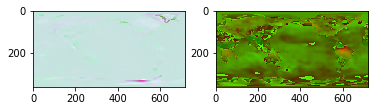

In [117]:
def getImFit(iname):
    pixels = np.asarray(Image.open(iname))
    (ix, iy, foo) = pixels.shape
    print(ix,iy)
    
    Irgrid = np.zeros((ix,iy))
    Iggrid = np.zeros((ix,iy))
    Ibgrid = np.zeros((ix,iy))
    Iagrid = np.zeros((ix,iy))
    for i in range(ix):
        for j in range(iy):
            Irgrid[i,j] = pixels[i,j,0]/255.
            Iggrid[i,j] = pixels[i,j,1]/255.
            Ibgrid[i,j] = pixels[i,j,2]/255.
            Iagrid[i,j] = pixels[i,j,3]/255.
        
    return Irgrid, Iggrid, Ibgrid, Iagrid, pixels

Ir1grid, Ig1grid, Ib1grid, Ia1grid, im1 = getImFit('GRACEfit_1.png')
Ir2grid, Ig2grid, Ib2grid, Ia2grid, im2 = getImFit('GRACEfit_2.png')

print(im1.shape, im2.shape)
f,ax = plt.subplots(1,2)
ax[0].imshow(im1)
ax[1].imshow(im2)

In [118]:
def getCmwe(t, p1, p2):
    f1 = p1[0]*t**3. + p1[1]*t**2. + p1[2]*t**1. + p1[3]
    #f1 = p1[0]*t**4. + p1[1]*t**3. + p1[2]*t**2. + p1[3]*t + p1[4]
    #f1 = p1[0]*t**5. + p1[1]*t**4. + p1[2]*t**3. + p1[3]*t**2. + p1[4]*t + p1[5]
    f2 = p2[0]*np.sin(2.*np.pi*(t + p2[1]))
    return (f1 +  f2) 

In [119]:
print("rgba1 min : ", r1min, g1min, b1min, a1min)
print("rgba1 max : ", r1max, g1max, b1max, a1max)
print("rgba2 min : ", r2min, g2min)#, b2min, a2min)
print("rgba2 max : ", r2max, g2max)#, b2max, a2max)
print("t0 : ", t0)
print("tf : ", max(mascons['yr'][2]))
print()

t = mascons['yr'][2] - t0

rf1 = Ir1grid * (r1max - r1min) + r1min
gf1 = Ig1grid * (g1max - g1min) + g1min
bf1 = Ib1grid * (b1max - b1min) + b1min
af1 = Ia1grid * (a1max - a1min) + a1min

rf2 = Ir2grid * (r2max - r2min) + r2min
gf2 = Ig2grid * (g2max - g2min) + g2min
#bf2 = Ib2grid * (b2max - b2min) + b2min
#af2 = Ia2grid * (a2max - a2min) + a2min

p1 = np.array([rf1, gf1, bf1, af1])#, bf2])#, af2])
p2 = np.array([rf2, gf2])

cG = mascons['cmwe'].copy()
for i in range(len(cG[0,:])):
    cG[:,i] *= mascons['area_km2']*1e-5
cmin = 0.
cmax = 0.
for i,tt in enumerate(t):
    cAll = getCmwe(tt, p1, p2)
    cmin = np.min([np.min(cAll), cmin])
    cmax = np.max([np.max(cAll), cmax])
print("fit(all t) min, max :", cmin, cmax)
print("cmwe(all t) min, max :", min(cG.flatten()), max(cG.flatten()))
print()


rgba1 min :  -0.0222 -1.1247 -5.051 -15.8233
rgba1 max :  0.0461 0.5629 3.0189 32.3872
rgba2 min :  -3.9773 -0.3349
rgba2 max :  8.284 0.3329
t0 :  2003.0150684931507
tf :  2016.535519125683

fit(all t) min, max : -58.75828132520898 32.96375966636377
cmwe(all t) min, max : -56.14183452995301 34.58935093038941



fit(t[ti]) min, max :  -58.75828132520898 27.031179820358503
cmwe(t[ti]) min, max :  -54.43169734420777 22.11860199609375
mean(fit(t=0)) :  -0.08797738111628617


/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(41168,) (360, 720)
range, mean, stdev of data - model :  [-54.69016949654027, 59.12667314062341] 1.189883794346258 3.462090936937294


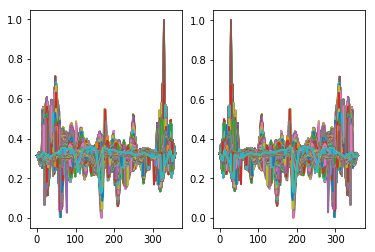

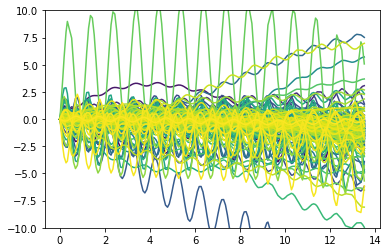

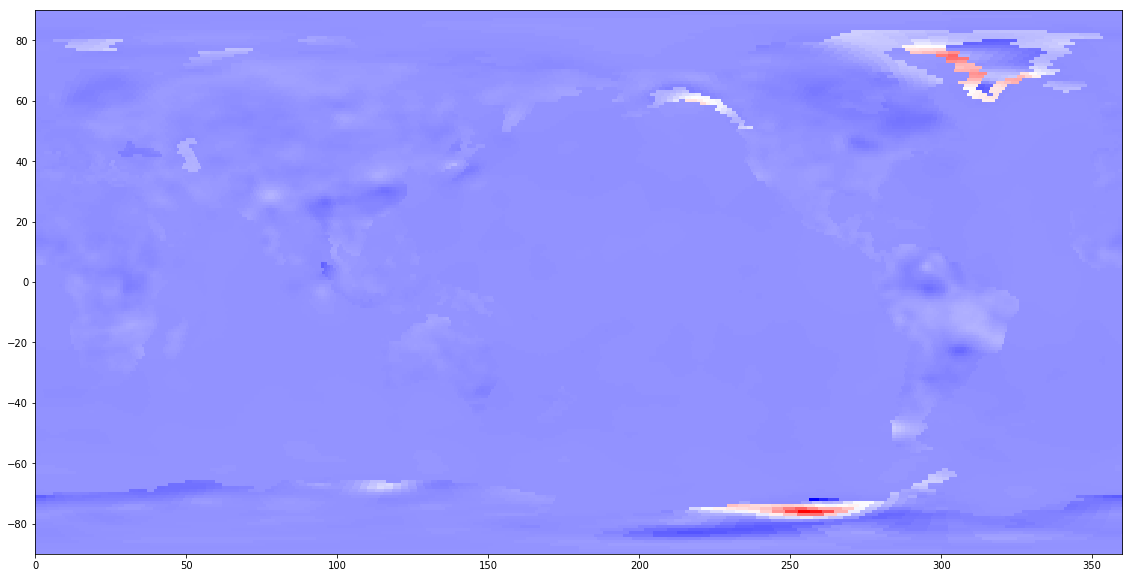

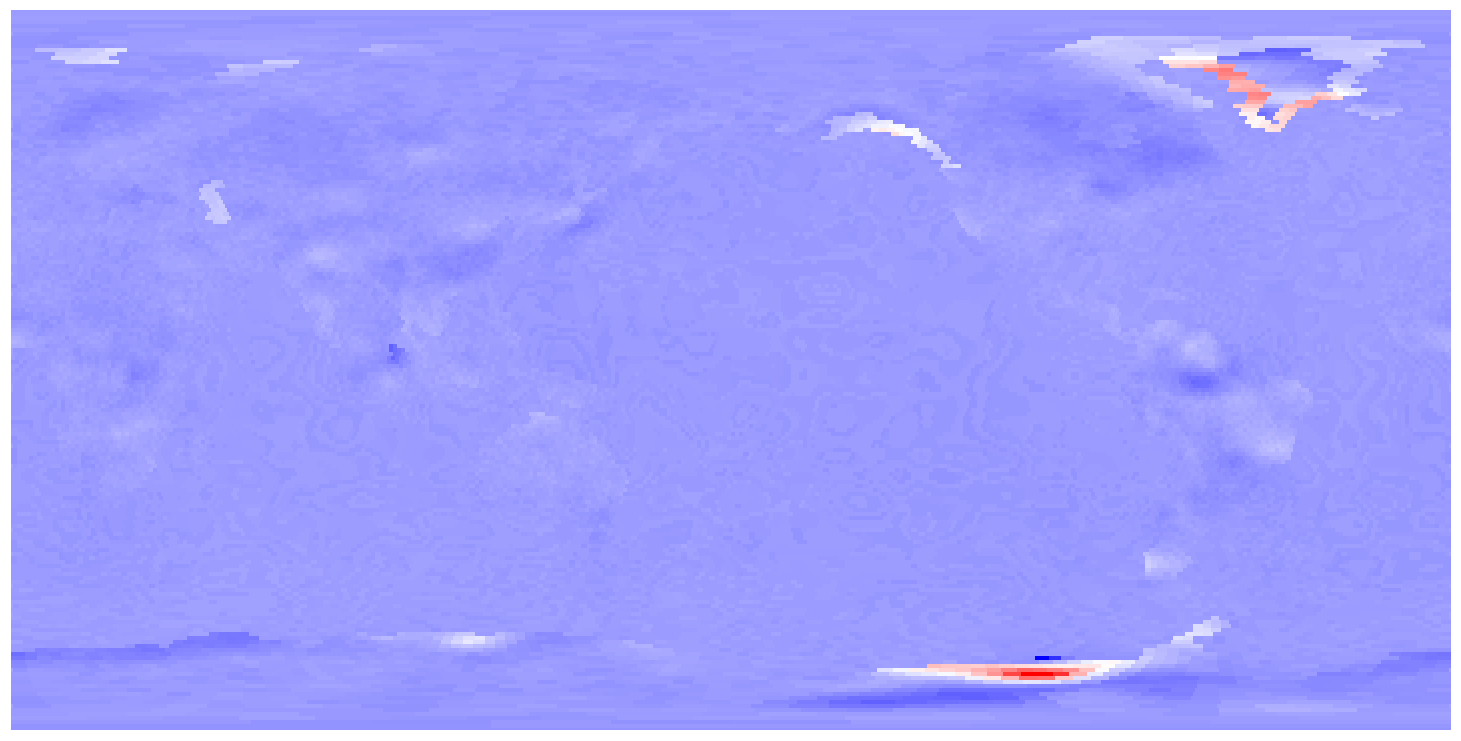

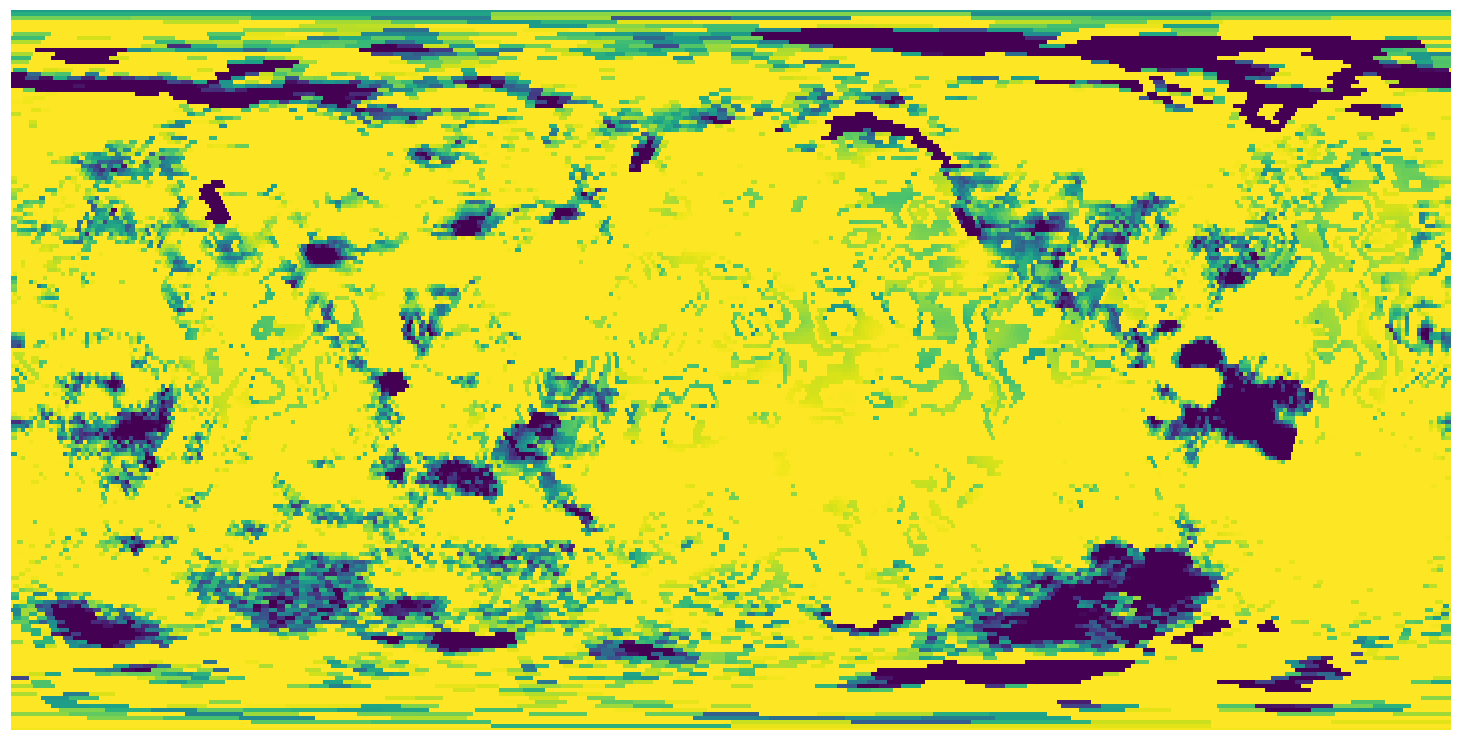

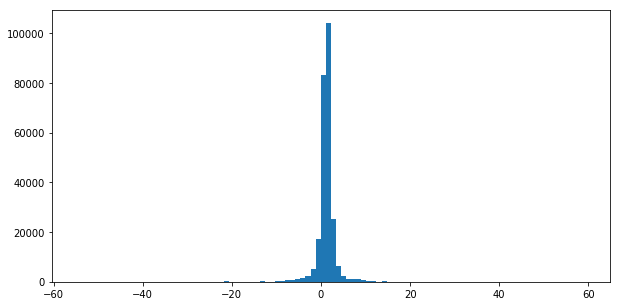

In [121]:
ti = len(t)-1

f, ax = plt.subplots(1,2)
ax[0].plot(Ir1grid)
ax[1].plot(r1grid)


c =  getCmwe(t[ti], p1, p2)
ct0 =  getCmwe(t[0], p1, p2)

print("fit(t[ti]) min, max : ", min(c.flatten()), max(c.flatten()))
z = mascons['cmwe'][:,ti] * mascons['area_km2']*1e-5
print("cmwe(t[ti]) min, max : ", min(z),max(z))
print("mean(fit(t=0)) : ", np.mean(ct0))

cmap = plt.get_cmap('viridis') 
f = plt.figure()
plt.ylim(-10,10)
p10f = p1[0].flatten()
p11f = p1[1].flatten()
p12f = p1[2].flatten()
p13f = p1[3].flatten()
#p14f = p1[4].flatten()
#p15f = p1[5].flatten()
p20f = p2[0].flatten()
p21f = p2[1].flatten()
choose = np.random.randint(low = 0, high = len(p10f)-1, size = 255)
for ic, i in enumerate(choose):
    #f1 =  p10f[i]*t**5. + p11f[i]*t**4. + p12f[i]*t**3. + p13f[i]*t**2. +  p14f[i]*t + p15f[i]
    #f1 =  p10f[i]*t**4. + p11f[i]*t**3. + p12f[i]*t**2. + p13f[i]*t +  p14f[i]
    f1 =  p10f[i]*t**3. + p11f[i]*t**2. + p12f[i]*t**1. + p13f[i]
    f2 = p20f[i] * np.sin(2.*np.pi*(t + p21f[i]))
    cAll = (f1 +  f2) 
    #cAll0 = p15f[i] +  p20f[i] * np.sin(2.*np.pi*p21f[i])
    #cAll0 = p14f[i] +  p20f[i] * np.sin(2.*np.pi*p21f[i])
    cAll0 = p13f[i] +  p20f[i] * np.sin(2.*np.pi*p21f[i])

    plt.plot(t,cAll - cAll0, c=cmap(ic))

#vmin = min((c-ct0).flatten())
#vmax = max((c-ct0).flatten())
vmin = min(z)
vmax = max(z)

cmap = plt.get_cmap('bwr_r') 

extent = [0, 360, -90, 90]
zgrid = makeCmweGrid(ti, Ngrid*2., Ngrid, extent = extent)
f,ax = plt.subplots(1,1, figsize=(20, 10))
ax.imshow(zgrid, extent = extent, origin="lower", vmin=vmin, vmax=vmax, cmap = cmap)


f = plt.figure(figsize=(20,10), frameon=False)
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
im = ax.imshow(c, extent=extent, aspect='equal', origin="upper", \
                 vmin=vmin, vmax=vmax, transform=proj, cmap = cmap)

diff = zgrid - c
f = plt.figure(figsize=(20,10), frameon=False)
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
ax.imshow(diff, extent=extent, aspect='equal', origin="lower", \
                 vmin=-1, vmax=1, transform=proj)

rng = [np.min(diff.flatten()), np.max(diff.flatten())]
print("range, mean, stdev of data - model : ", rng, np.mean(diff.flatten()), np.std(diff.flatten()))
f = plt.figure(figsize=(10,5))
x = plt.hist(diff.flatten(), bins=100, range=rng)


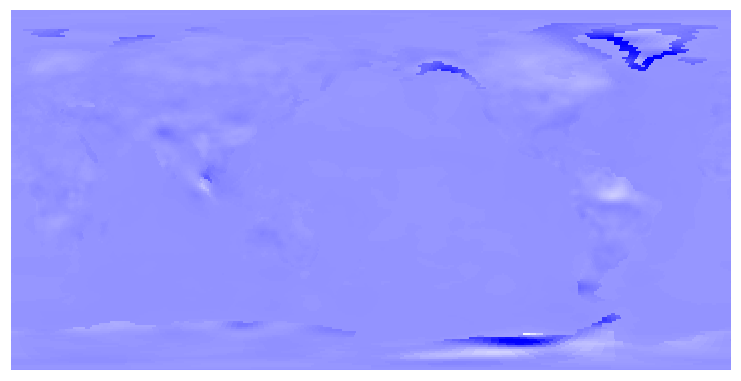

In [122]:
cmap = plt.get_cmap('bwr_r') 

c =  getCmwe(t[0], p1, p2)

f = plt.figure(figsize=(10,5), frameon=False)
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
im = ax.imshow(c, extent=[0, 2, 0, 1], aspect='equal', origin="upper", \
                 vmin=vmin, vmax=vmax, transform=proj, cmap = cmap)

def init():
    c =  getCmwe(0, p1, p2)
    im.set_data(c)

def animate(i):
    c =  getCmwe(t[i], p1, p2)
    im.set_data(c - ct0)
    return im

anim = animation.FuncAnimation(f, animate, init_func=init, frames=len(t), interval=50)

In [123]:
HTML(anim.to_html5_video())

## Image with coastlines

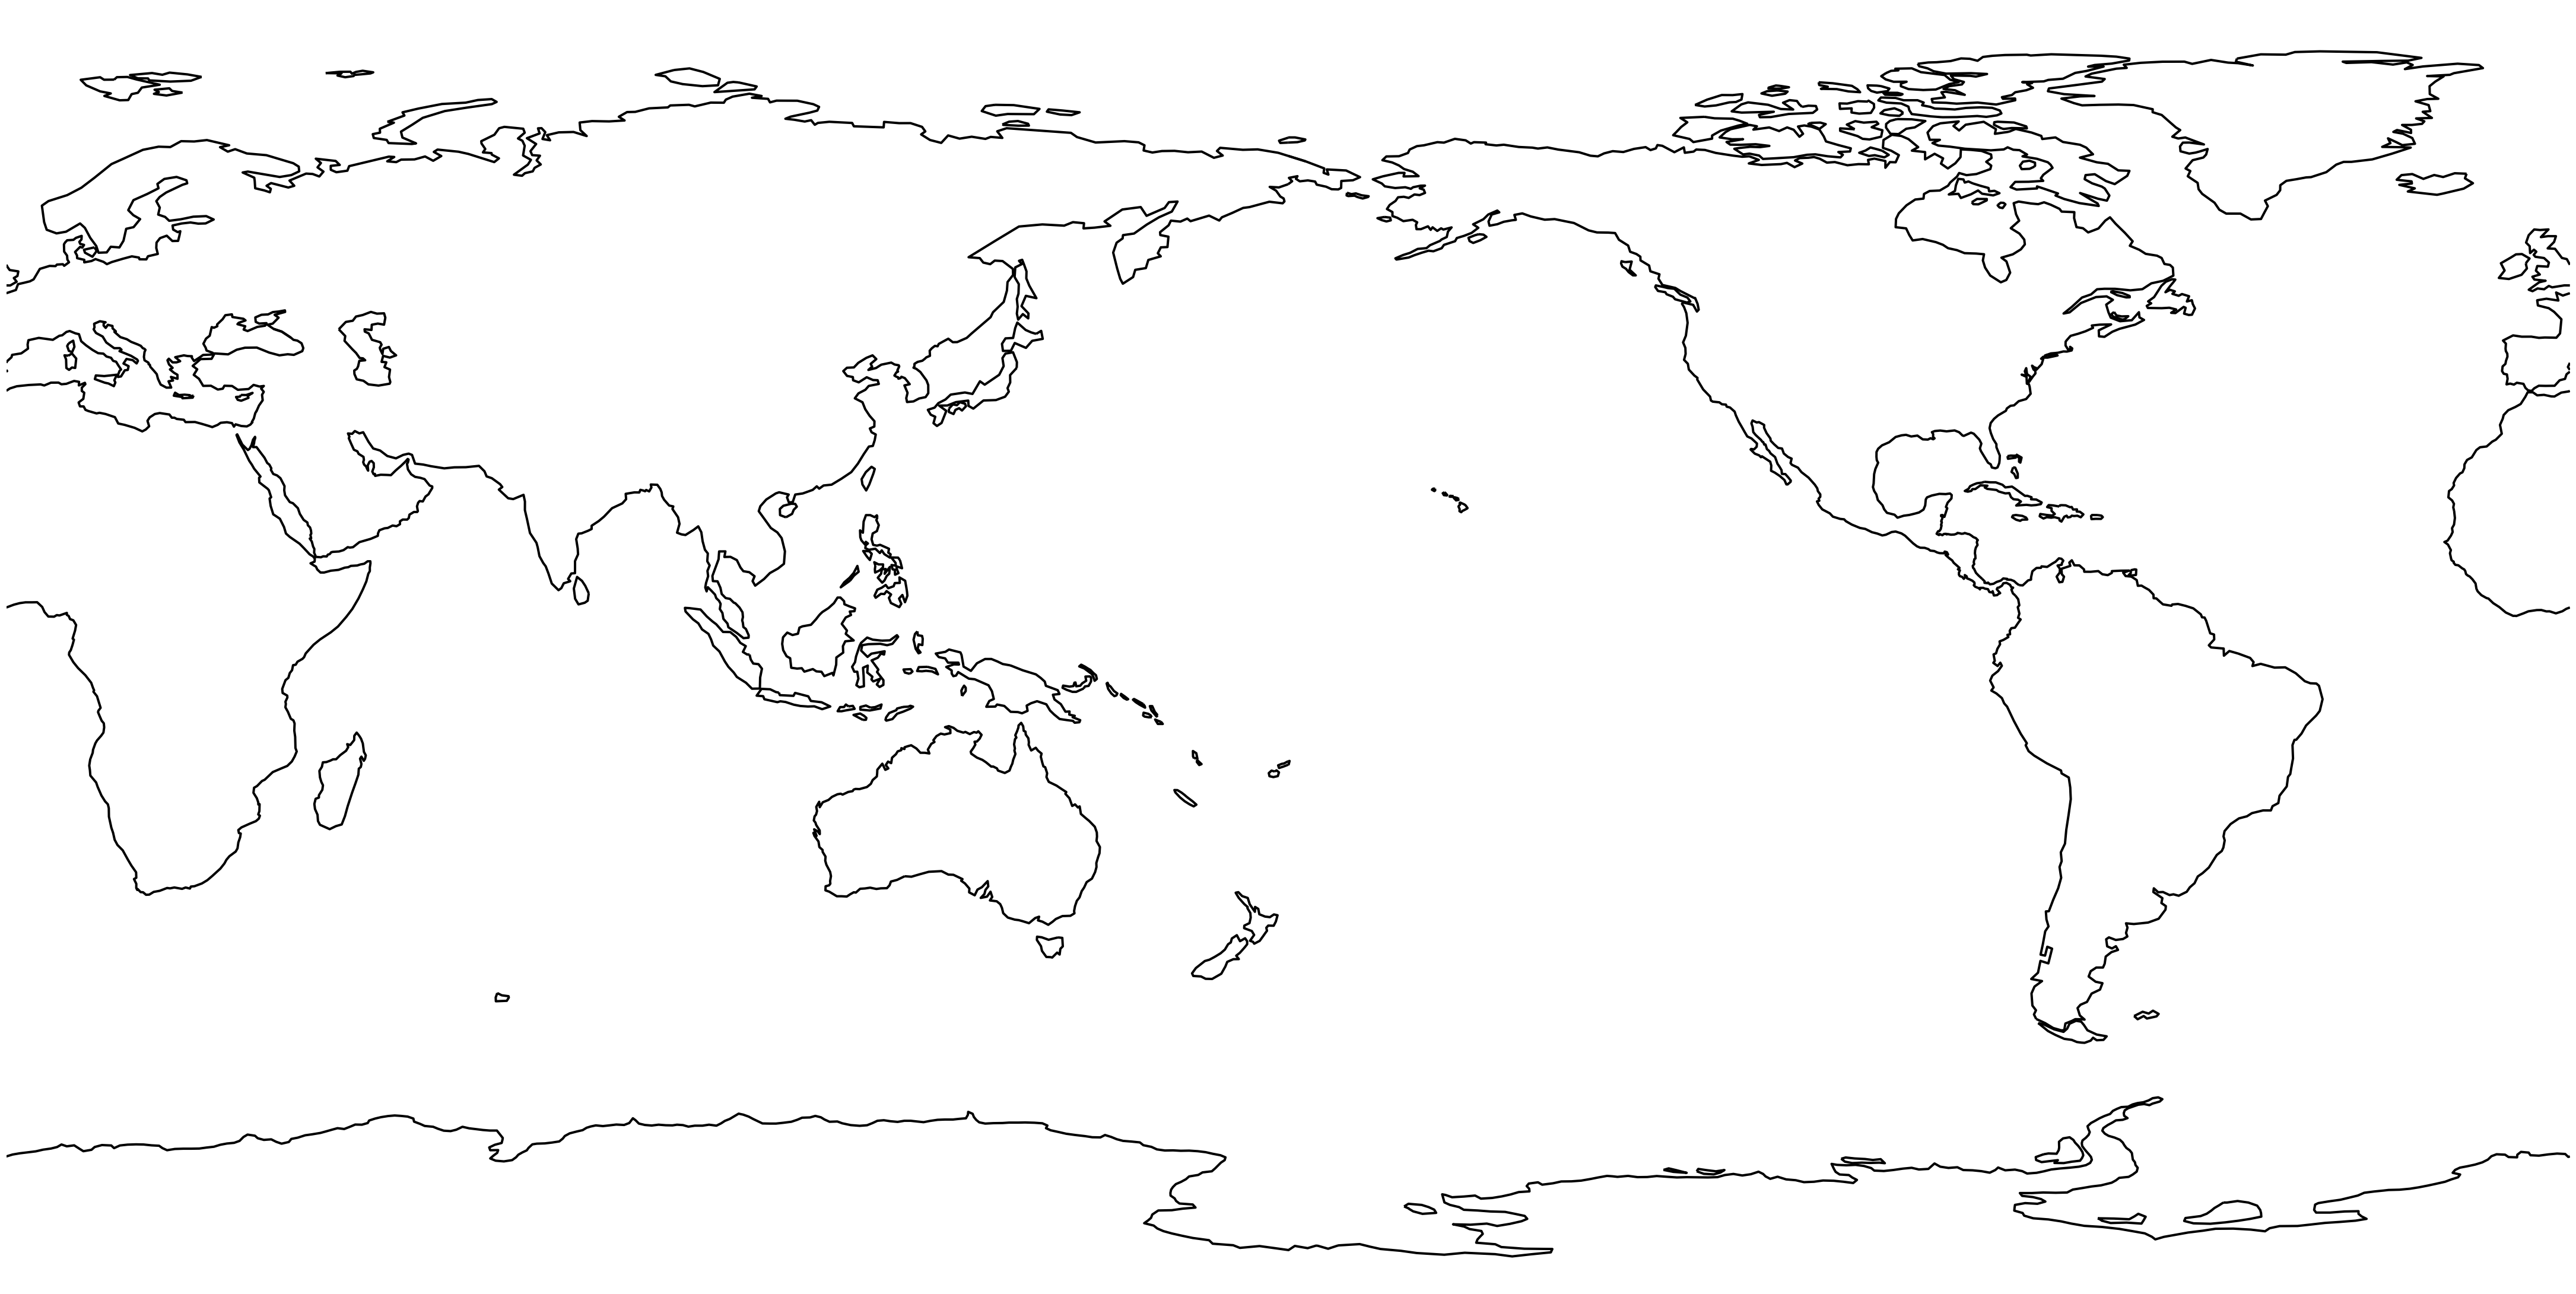

In [125]:
import cartopy 
f = plt.figure(figsize=(60,30), frameon=False) #72 dpi
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
#ax.coastlines(color='black', linewidth=4)
#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth = 4)
#ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
#ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
#ax.add_feature(cartopy.feature.RIVERS, alpha=0.5)

f.savefig("CoastLines.png", bbx_inches = 'tight', pad_inches = 0,)